# Benchmark for the Single-Cell rna data.

Here we present the construction of the EOT benchmark pairs $\widehat{\mathbb{P}}_0$ and $\widehat{\mathbb{P}}_1$ for the single-cell data used to evaluate the SB algorithms in the paper [1]. 

[1] Koshizuka T., Sato I. Neural Lagrangian Schr\"{o} dinger Bridge: Diffusion Modeling for Population Dynamics //The Eleventh International Conference on Learning Representations. – 2022.

In [1]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from eot_benchmark.gaussian_mixture_benchmark import ConditionalPlan

import torch

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

### Data loading

In [2]:
train_data = np.load("train_rna.npz")
ts_train = train_data['ts']
X_train = train_data["X"][train_data['ts'] == 0].astype("float32")
Y_train = train_data["X"][train_data['ts'] == 4].astype("float32")

pca = PCA(n_components=5)
pca.fit(train_data["X"])
X_train = pca.transform(X_train).astype("float32")
Y_train = pca.transform(Y_train).astype("float32")

### Hyperparameters

In [3]:
N_CLUSTERS = 250
SIGMA = 1. # \lambda = EPS / SIGMA due to different parametrization in code
EPS = 100

### Benchmark construction

In [4]:
DIM = X_train.shape[1]
k_means = KMeans(n_clusters=N_CLUSTERS)
k_means.fit(Y_train)

potential_probs = torch.ones(N_CLUSTERS)/N_CLUSTERS
potential_mus = torch.tensor(k_means.cluster_centers_).float()
potential_sigmas = torch.diag(torch.tensor([SIGMA]*DIM))[None, :].repeat(N_CLUSTERS, 1, 1)

conditional_plan = ConditionalPlan(potential_probs, potential_mus, potential_sigmas, eps=EPS, device="cpu")

### TSNE visualization 

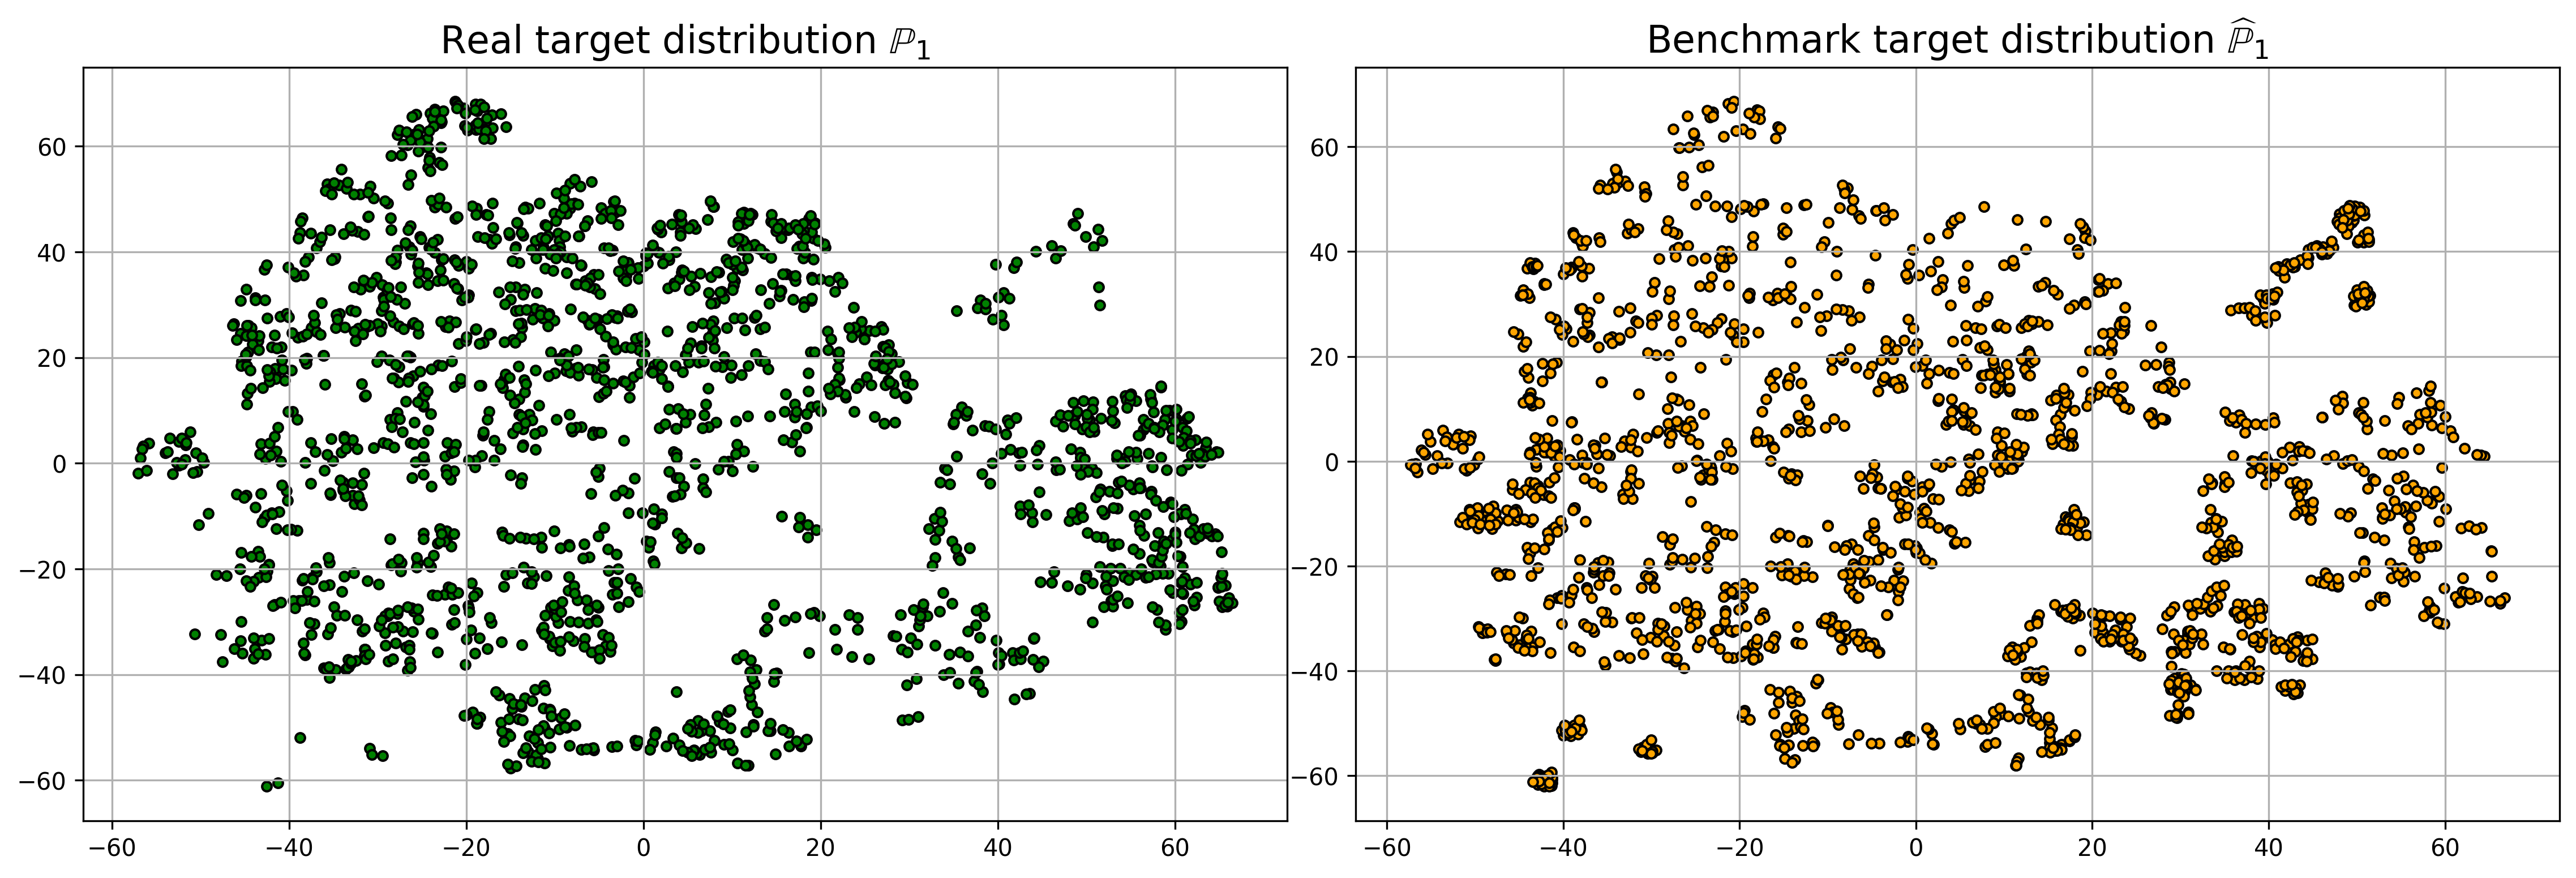

In [5]:
tsne = TSNE()

plan_train_samples = conditional_plan.sample(torch.tensor(X_train)).detach().cpu().numpy()
np.random.shuffle(Y_train)
Y_train_subsample = Y_train[:plan_train_samples.shape[0]]  # subsample to have the same size for better comparison

labels = np.array([0]*Y_train_subsample.shape[0] + [1]*plan_train_samples.shape[0])
tsne_values = tsne.fit_transform(np.concatenate((Y_train_subsample, plan_train_samples), axis=0))

fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

axes[0].scatter(tsne_values[labels==0, 0], tsne_values[labels==0, 1], c="g", s=16, edgecolors="black")
axes[0].grid()
axes[0].set_title(r"Real target distribution $\mathbb{P}_1$", fontsize=16)

axes[1].scatter(tsne_values[labels==1, 0], tsne_values[labels==1, 1], c="orange", s=16, edgecolors="black")
axes[1].grid()
axes[1].set_title(r"Benchmark target distribution $\widehat{\mathbb{P}}_1$", fontsize=16)

fig.tight_layout(pad=0.1)
plt.savefig("TSNE_rna.png")
plt.show()